### EDA и варианты решения

Задача intent detection сводится к мультиклассовой классификации, поэтому здесь я хочу проверить 
характеристики датасета, которые могут влиять на качество классификатора:
  * количество классов
  * количество сэмплов по классам
  * баланс классов
  * наличие доминирующего класса (или нескольких) 
  * наличие outliers
  
В отношении самих текстов, проверяю, нужен ли какой-то препроцессинг.

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml

In [4]:
!ls ../data

hello_nova_intents_0.2.2.yaml


In [22]:
with open('../data/hello_nova_intents_0.2.2.yaml', 'r') as file:
    documents = yaml.full_load(file)
    
    samples = []
    for entry in documents['data']:
        intent = entry['intent']
        for example in entry['examples']:
            samples.append((example, intent))

In [25]:
df = pd.DataFrame(samples, columns=['text', 'intent'])
df.head(30)

,text,intent
0,Hi,Hello
1,Hello,Hello
2,"Hi, bot",Hello
3,Good morning,Hello
4,Good afternoon,Hello
5,Good evening,Hello
6,Morning,Hello
7,Evening,Hello
8,Hey,Hello
9,Good day,Hello


In [29]:
df.describe()

,text,intent
count,483,483
unique,472,71
top,How are you different from other bots?,How does it work?
freq,2,28


In [43]:
df['intent'].value_counts()

How does it work?               28
ask_name                        14
(2) 24/7 support                13
How are you?                    11
(1) language                    11
                                ..
Can I trust you?                 2
What are you based on?           2
Why can't you understand me?     1
Are you a human?                 1
What is this for?                1
Name: intent, Length: 71, dtype: int64

<AxesSubplot:>

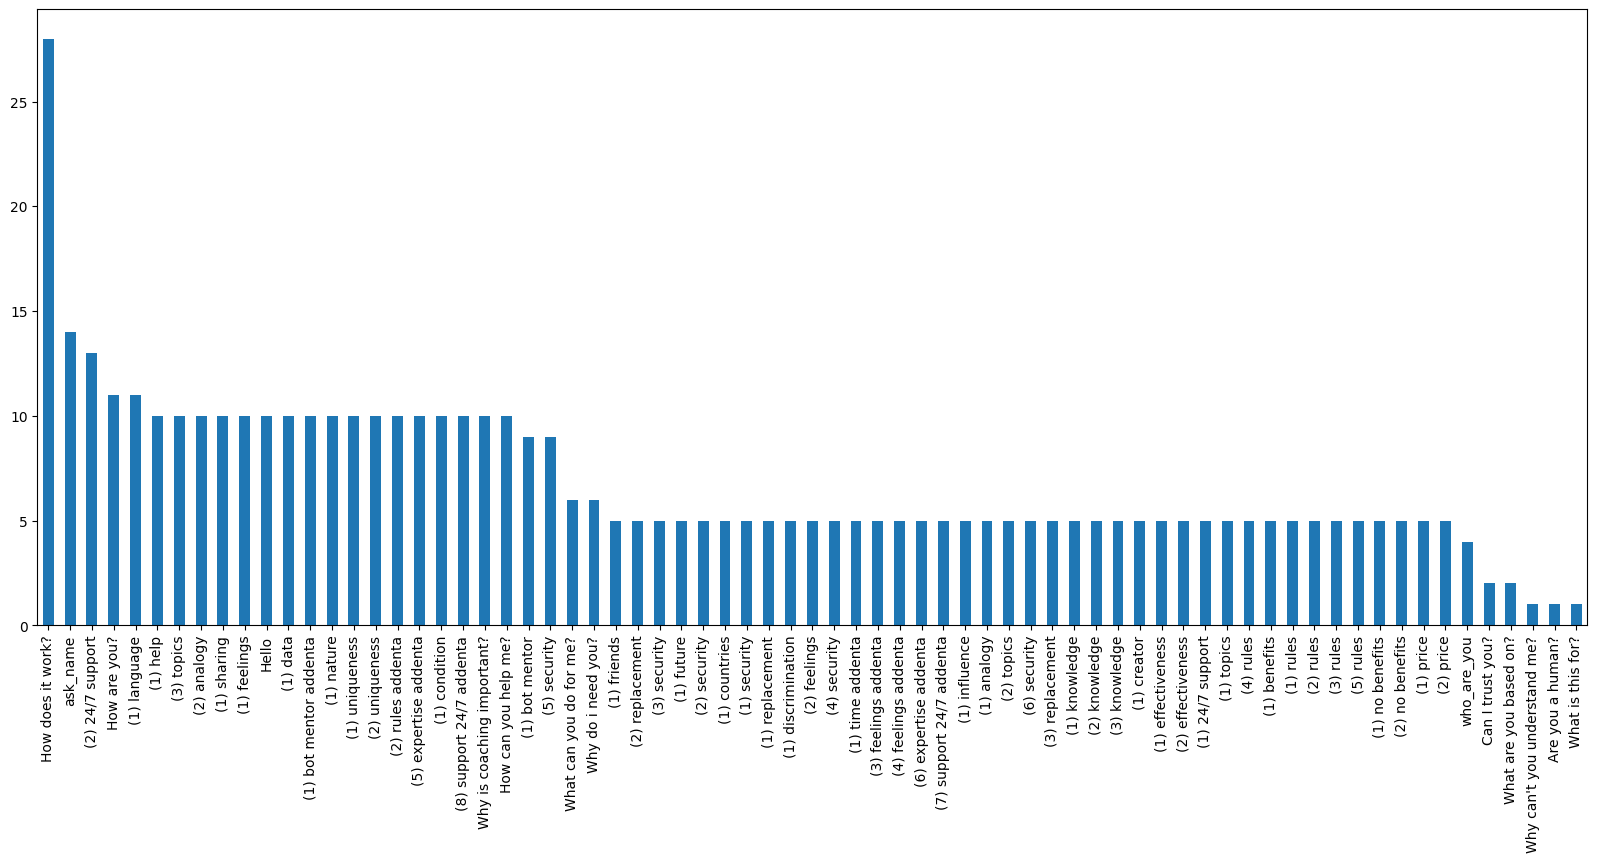

In [48]:
df['intent'].value_counts().plot(kind='bar', figsize=(20, 8))

**Дополнительные соображения по поводу текстов.**

Вообще, делать multiclass классификатор в лоб (типа дообучить BERT) на этом датасете кажется безнадежной затеей, т.к. данных очень мало, сделать даже stratified split на train/test не получится, т.к. некоторые классы представлены в единичном экземпляре, проверить обобщающую способность даже с кросс-валидацией будет затруднительно.

Однако, можно можно подойти к решению задачи по-другому. Многие названия интентов даны в текстовой форме (достаточно осмысленной), поэтому можно решать не задачу классификации в лоб, а сделать предварительный поиск в пространстве векторных представлений для предложений. Это может хорошо сработать для интентов вида "Hello", "How does it work?" и интентов с одним-двумя сэмплами, т.к. можно убрать из рассмотрения часть интентов, а для остальных разбить один классификатор на несколько класификаторов поменьше.

Есть группа интентов с одинаковым названием, различающихся номером (напр., "(1) security", "(2) security"). Предварительный поиск по запросу может позволить свести задачу к классификации в пределах "номерной группы", для которой может быть лучше баланс классов и меньше число классов (решать проще).

Т.о. концепция решения следующая:
  * названия интентов нормализуются (split по подчеркиванию, чтобы получилась фраза - 2 шт, из номерных интентов удаляются номера, дубликаты удаляются), формируется список target phrases
  * с помощью BERT делается sentence embedding (\[CLS\] токен) для входной фразы и target phrases, затем делается поиск ближайшей target phrase
  * часть target phrase рассматриваются как outliers для основной задачи классификации. Если попали в них, то считаем сразу за ответ (таких будет "How does it work?", "Can I trust you?", "What are you based on?", "Why can't you understand me?", "Are you a human?", "What is this for?" -- всего 6 шт.) 
  * Часть target phrases представляют собой осмысленные фразы и не содержат номера ("ask_name", "How are you?", "Hello", "Why is coaching important?", "How can you help me?", "What can you do for me?", "Why do I need you?", "Who are you?" -- всего 8 шт.) Попадание в них при сравнении эмбеддингов также сразу считаем за ответ.
  * Часть номерных интентов содержат всего один номер (напр., "(1) nature") -- таких всего 15
  * часть интентов совпадает по названию, но содержит доп. помету "addenda", напр., "(1) bot mentor" и "(1) bot mentor addenda". Этих нужно трактовать как номерные из одной группы. (Вообще, помета addenda проставлена непоследовательно, иногда есть и в номерных)
  * Для номерных интентов c числом вариантов >= 2 (таких 13 шт.) делаются отдельные "уменьшенные" классификаторы (можно на scikit-learn), рассматриваем полученные ранее embeddings как фичи. Например, "knowledge" - классификация на 3 класса. Т.е. если на этапе определения target phrase попали в knowledge - дополнительно используем этот классификатор для выбора из 3 вариантов.
  
Ну и дополнительно можно сделать группировку классов (все номерные, все с addenda, все с 1-2 примерами сгруппировать в other), обучить BERT в лоб.

И в конце сделать ансамбль из 1) BERT на сгруппированных классах, 2) distance-based на эмбеддингах, 3) 13-15 мини-классификаторов. Тестить на кросс-валидации. 
  